#### The problem statement is  to predict whether a passenger in the titanic ship wreck would survive or not

From the Titanic dataset, The features present in the dataset are:

- Survived: Outcome of survival (0 = No; 1 = Yes)
- Pclass: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- Name: Name of passenger
- Sex: Sex of the passenger
- Age: Age of the passenger (Some entries contain NaN)
- SibSp: Number of siblings and spouses of the passenger aboard
- Parch: Number of parents and children of the passenger aboard
- Ticket: Ticket number of the passenger
- Fare: Fare paid by the passenger
- Cabin Cabin number of the passenger (Some entries contain NaN)
- Embarked: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)


#### Importing the neccesary libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import  ColumnTransformer
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
plt.style.use('ggplot')

#### Loading the dataset

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Checking the descriptive statistics of the data

In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Checking for duplicate values in the dataset so that it can be removed so as to clean the data

In [44]:
data.duplicated().sum()

105

#### Checking the information of the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Observation : *Null Values are present and also categorical data present*
#### Action : *Checking for the null values and their columns*

#### Checking for the null values

In [5]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Observation: *Age, Cabin and Embarked columns have null values*
#### Action:  *Removing the cabin column and then using the KNNImputer to fill in the missing values of the two other columns*

From the above, it can be observed that there are missing values in some columns like (Age, Cabin and Embarked) and also the dataset also contains some categorical data that needs to be encoded (Name, Sex, Ticket, Cabin and Embarked)

#### Dropping the cabin columns

In [6]:
data = data.drop(columns = ['Cabin'])
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


#### Creating a new column called title

In [7]:
def title_extractor(fullname): 
    title = fullname.split(',')[1].strip().split(' ')[0]
    return title

A new feature called Title is created from the Name feature

In [8]:
data['Title'] = data['Name'].map(title_extractor)

In [9]:
data.Title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the',
       'Jonkheer.'], dtype=object)

In [10]:
def changing_title(title): 
    titles = ['Mr.', 'Mrs.', 'Master.', "Miss."]
    if(title not in titles): 
        return 'Others'
    else: 
        return title

In [11]:
data.Title = data.Title.map(changing_title)

In [12]:
data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S,Mr.


#### Dropping irrelevant columns : Name, Ticket, PassengerId

In [13]:
data = data.drop(columns = ['Name', 'Ticket', 'PassengerId'])

In [14]:
data.shape

(891, 9)

In [15]:
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,Miss.


#### Encoding the Sex Columns 

In [16]:
data["Sex"] = np.where(data['Sex'] == 'male', 1, 0)

In [17]:
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,S,Mr.
1,1,1,0,38.0,1,0,71.2833,C,Mrs.
2,1,3,0,26.0,0,0,7.9250,S,Miss.


#### Encoding the Embarked Column

In [18]:
data.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [19]:
embarked_mapping = {"S" : 1, 'C' : 2, 'Q' : 3}

In [20]:
data.Embarked = data.Embarked.map(embarked_mapping)

In [21]:
data.Embarked.unique()

array([ 1.,  2.,  3., nan])

#### Encoding the Title column

In [22]:
data.Title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Others'], dtype=object)

In [23]:
title_mapping = {'Others': 5, 'Mr.':4, 'Mrs.':3, 'Master.':2, "Miss.":1}
data.Title = data['Title'].map(title_mapping)

In [24]:
data.Title.unique()

array([4, 3, 1, 2, 5], dtype=int64)

In [25]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,1.0,4
1,1,1,0,38.0,1,0,71.2833,2.0,3
2,1,3,0,26.0,0,0,7.9250,1.0,1
3,1,1,0,35.0,1,0,53.1000,1.0,3
4,0,3,1,35.0,0,0,8.0500,1.0,4


**Distribution of people that survived and those that did not**

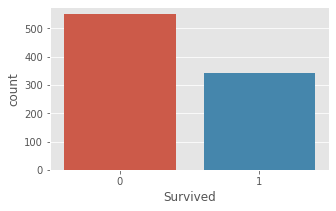

In [48]:
plt.figure(figsize=(5,3))
sns.countplot(data['Survived'])
plt.show()

From the above, it can be observed that more people did not survive

**Checking for the distribution of the gender present in the ship**

In [50]:
data['Sex'].value_counts()

1    577
0    314
Name: Sex, dtype: int64

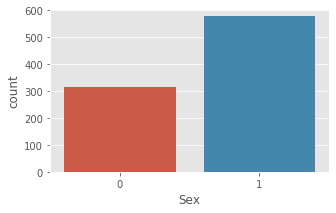

In [51]:
plt.figure(figsize=(5,3))
sns.countplot(data.Sex)
plt.show()

Male are reprsented as 1 while the female as 0, from the above it is obvious that there are more men present in the ship, male = 577  and female  = 314

In [52]:
data.groupby('Sex').Survived.value_counts()

Sex  Survived
0    1           233
     0            81
1    0           468
     1           109
Name: Survived, dtype: int64

- Male = 1
- Female = 0
- From the above 
- Female that survived = 233
- Female that did not survive = 81
- Male that survive = 109
- Male that did not survive = 468


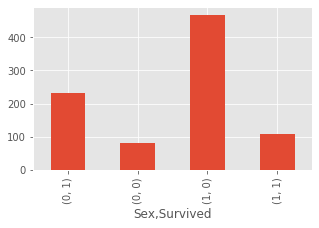

In [54]:
plt.figure(figsize=(5,3))
data.groupby('Sex').Survived.value_counts().plot(kind='bar')
plt.show()

#### Splitting the data into train and test

In [26]:
sample_size = data.shape[0]
train_size = int(0.8  * sample_size)
test_size = int(sample_size - train_size)
train = data.iloc[:train_size+1, :]
test = data.iloc[train_size+1: , :]

#### Using the KNNImputer for the missing values of the dataset

In [27]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
train = imputer.fit_transform(train)
test = imputer.fit_transform(test)

#### Splitting into the independent and dependent variable

In [28]:
cols = list(data.columns)
X_cols = cols[1:]
y_cols = cols[0]
X_train =train[:, 1:]
y_train = train[: , 0]
X_test = test[:, 1:]
y_test = test[:, 0]


This process involve splitting the data into train and test data, one of  the purpose of splitting is so that when tranformation will done differently on the train and test so as to avoid bias in the dataset and also the test data will be used to evaluate the model

#### checking for the correlation of the data

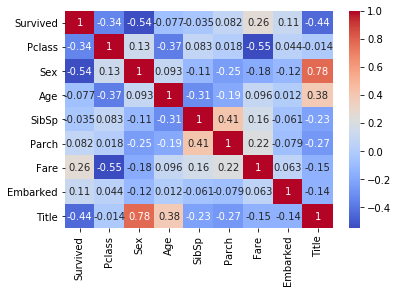

In [29]:
import seaborn as sns
cor = data.corr()
cm = sns.heatmap(cor, annot = True, cmap='coolwarm')

####  Checking for correlation greater than or equal to 0.8 

In [30]:
result= []
for col1 in cols:
    for col2 in cols: 
        if(col1 != col2):
            cor_data = data[col1].corr(data[col2])
            if(cor_data > .8):
                result.append(f'{col1} : {col2}: {cor_data}')
                

print(set(result))

set()


#### Observation: *There are no columns with correlation greater than 0.8*

If there was any, then it will be removed

#### Scaling the data using the standard scaler.

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Importing all the necesary ML Models

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [34]:
algorithms = {
    'Logistic Regression' : {
        'model' : LogisticRegression(),
        'params' : {
                'C'       : [i for i in range(1,6)],
                'fit_intercept' : [True, False]
        }
    },
    
    'SVM' : {
        'model': SVC(),
        'params': {
            'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
            'C'      : [i for i in range(1,6)],
            'degree' : [i for i in range(2,6)]
        }
    }, 

    'Random Forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators': [i for i in range(50, 300, 50)],
            'criterion' : ['gini', 'entropy']
        }
    },
    'Extra Tree Classifier' : {
        'model' : ExtraTreesClassifier(),
        'params' : {
            'n_estimators': [i for i in range(50, 300, 50)],
            'criterion' : ['gini', 'entropy']
        }
    },
    
    'XGBoost' : {
        'model' : XGBClassifier(),
        'params' : {
            'n_estimators': [i for i in range(50, 300, 50)]
        }
    },
    
    'Decision Tree' : {
        'model' : DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random']
        }
    },
    
    'KNN' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : [i for i in range(3, 9, 2)],
            'weights' : ['uniform', 'distance']
            
        }
    },
    
    'Ada Boost' : {
        'model' : AdaBoostClassifier(),
        'params' : {
            'n_estimators': [i for i in range(40, 120, 20)],
            'algorithm' : ['SAMME', 'SAMME.R'],
        }
    },
    
    'Naive Bayes' : {
        'model' : GaussianNB(), 
        'params' :{}
    }
    
}

In [35]:
accuracies = []

In [36]:
for model, param in algorithms.items():
    classifier = GridSearchCV(param['model'], param_grid = param['params'], cv=5, scoring='accuracy', verbose=1)
    classifier.fit(X_train,y_train)
    result = {'Model Name': model, 'best score' : classifier.best_score_, 'best params': classifier.best_params_}
    accuracies.append(result)
    classifier.get_params()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[13:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jeremiah\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[13:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [37]:
result = pd.DataFrame(accuracies)
result = result.sort_values(by='best score', ascending=False)
result

,Model Name,best score,best params
1,SVM,0.819049,"{'C': 2, 'degree': 2, 'kernel': 'rbf'}"
2,Random Forest,0.816301,"{'criterion': 'entropy', 'n_estimators': 50}"
6,KNN,0.814922,"{'n_neighbors': 5, 'weights': 'uniform'}"
4,XGBoost,0.809248,{'n_estimators': 50}
3,Extra Tree Classifier,0.806461,"{'criterion': 'entropy', 'n_estimators': 250}"
7,Ada Boost,0.803644,"{'algorithm': 'SAMME.R', 'n_estimators': 100}"
0,Logistic Regression,0.786812,"{'C': 1, 'fit_intercept': True}"
5,Decision Tree,0.776972,"{'criterion': 'entropy', 'splitter': 'random'}"
8,Naive Bayes,0.776953,{}


#### From the above result, it can be seen that SVM has the highest accuracy

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [39]:
classif = SVC(kernel='rbf', C=2, degree=2)
classif.fit(X_train, y_train)
y_pred = classif.predict(X_test)
train_pred= classif.predict(X_train)
acc = accuracy_score(y_test, y_pred)
acc_train = accuracy_score(y_train , train_pred)
print(f'Training accuracy ==> {acc_train * 100}')
print(f'Testing accuracy ==> {acc*100}')

Training accuracy ==> 83.87096774193549
Testing accuracy ==> 88.76404494382022


**The testing accuracy of the is *88.76***

In [40]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[110,   5],
       [ 15,  48]], dtype=int64)

In [41]:
cr = classification_report(y_pred, y_test)
print(cr)

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92       125
         1.0       0.76      0.91      0.83        53

    accuracy                           0.89       178
   macro avg       0.86      0.89      0.87       178
weighted avg       0.90      0.89      0.89       178



In [55]:
#### End of the model


#### ======================================================

#### =======================================================